In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# define turtle class
class TurtleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Purpose: The constructor function initializes the dataset object with essential parameters and prepares the data for loading.
        Stores the image and mask directory paths.
        Loads and sorts the filenames in both directories (image_files and mask_files) to ensure that each image matches the corresponding mask file by index.
        Stores any transformations for potential application later in the __getitem__ method.
        """
        # store image directory path
        self.image_dir = image_dir
        # Store tag directory path
        self.mask_dir = mask_dir
        # Get and sort the list of image files
        self.image_files = sorted(os.listdir(image_dir))
        # Get and sort the list of tag files
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Constructs the file paths for the image and mask using the index.
        Loads the image and mask files as grayscale images using OpenCV (cv2.IMREAD_GRAYSCALE).
        Modifies the mask's pixel values:
        Assigns each region (background, body, leg, and head) a unique class ID (0, 1, 2, or 3) for segmentation purposes.
        Applies any specified transformation to the image, if applicable.
        Converts the modified mask to a PyTorch tensor with a long integer type (torch.long) to be compatible with model training in segmentation tasks.
        Returns a tuple containing the transformed image and the mask.
        """
        # Get the current image path
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        # Get the current mask path
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        # read image and mask as grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Label regions with different pixel values as different classes
        mask[mask == 0] = 0   # background
        mask[mask == 85] = 1  # body
        mask[mask == 170] = 2  # leg
        mask[mask == 255] = 3  # head
        if self.transform:
            image = self.transform(image)
        # Convert labels to long tensors
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask 

In [ ]:
"""
Layers:
self.conv1: First convolutional layer that takes a single-channel (grayscale) input image and applies 32 convolutional filters with a 3x3 kernel. Padding of 1 ensures that the spatial dimensions of the output are the same as the input.
self.pool: A max-pooling layer with a 2x2 filter and stride of 2, which reduces the spatial dimensions by half. Pooling layers help reduce computation and control overfitting by focusing on essential features.
self.dropout: A dropout layer with a probability of 0.3. Dropout randomly deactivates 30% of neurons during training to help prevent overfitting.
self.conv2: Second convolutional layer with 64 filters, which further extracts higher-level features from the 32-channel input.
self.conv3: Third convolutional layer with 64 filters, allowing for deeper feature extraction without reducing spatial dimensions.
self.conv4: A final convolutional layer that reduces the 64-channel input to 4 output channels, each representing a segmentation class (background, body, leg, and head in the dataset).
self.upsample: An upsampling layer that increases the spatial dimensions by a factor of 4 using bilinear interpolation. This step brings the output back to the original image size, making it suitable for pixel-wise classification.
"""
"""
First Block: Applies conv1, followed by ReLU activation and max pooling, which extracts initial low-level features and reduces the spatial resolution.
Second Block: Applies conv2, followed by ReLU activation and max pooling again, further extracting features and downsampling the image.
Third Block: Applies conv3 and ReLU activation, which allows the model to learn more abstract features without changing the spatial dimensions.
Final Convolution: Uses conv4 to reduce the channel dimension to 4 (one per class), creating a feature map with class predictions for each pixel.
Upsampling: Uses the upsampling layer to scale the output feature map to the original input size, making it compatible for pixel-wise classification (segmentation).
Return Value: The upsampled feature map, which provides class scores for each pixel in the input image.  This can then be processed by a loss function during training or thresholded for class predictions during inference.
"""

In [3]:
# define simple CNN 
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolution layer, input channels=1, output channels=32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Max pooling layer with a 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
         # Dropout layer with a probability of 0.3
        self.dropout = nn.Dropout(0.3)
        # Second convolution layer, 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Third convolution layer, 64 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Final convolution layer, output channels=4, representing 4 classe
        self.conv4 = nn.Conv2d(64, 4, kernel_size=1)  
        # Upsampling to the original image size
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  

    def forward(self, x):
        # Apply conv1, ReLU, and max pooling
        x = self.pool(torch.relu(self.conv1(x)))
         # Apply conv2, ReLU, and max pooling
        x = self.pool(torch.relu(self.conv2(x)))
         # Apply conv3 and ReLU without pooling
        x = torch.relu(self.conv3(x))
        # Apply the final convolution layer conv4
        x = self.conv4(x)
        # Upsample the output to match the original input size
        x = self.upsample(x)  
        return x

In [16]:
# Data transformations
transform = transforms.Compose([
    # Convert images to PyTorch tensors
    transforms.ToTensor(),
])
# Create data loaders for training and validation datasets
train_dataset = TurtleDataset(image_dir='./img_train', mask_dir='./mask_train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #randomness
valid_dataset = TurtleDataset(image_dir='./img_valid', mask_dir='./mask_valid', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [17]:
# 初始化模型、损失函数和优化器
model = SimpleCNN()

In [19]:
 # Define the loss function as cross-entropy loss, suitable for multi-class classification
criterion = nn.CrossEntropyLoss()
# Initialize the Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
 # Learning rate scheduler that reduces LR by 50% if validation loss does not improve for 5 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training the model
# Define the number of training epochs
num_epochs = 30
for epoch in range(num_epochs):
     # Set the model to training mode
    model.train()
     # Initialize running loss for training
    running_loss = 0.0
    for images, masks in train_loader:
         # Zero the parameter gradients to avoid accumulation
        optimizer.zero_grad()
         # Forward pass: compute model output for input images
        outputs = model(images)
        # Compute the loss by comparing outputs and ground truth masks
        loss = criterion(outputs, masks)# Calculate the cross-entropy loss
         # Backward pass: compute gradients of loss with respect to model parameters
        loss.backward()
         # Update model parameters based on gradients
        optimizer.step()
        running_loss += loss.item()# Accumulate batch loss for the epoch
    avg_train_loss = running_loss / len(train_loader) # Calculate the average training loss for the epoch
    
    model.eval()# Set the model to evaluation mode
    valid_loss = 0.0 # Initialize validation loss
     
    with torch.no_grad(): # Disable gradient computation for validation
        for images, masks in valid_loader:
            outputs = model(images) # Forward pass on validation images
            loss = criterion(outputs, masks) # Calculate the validation loss
            valid_loss += loss.item() # Accumulate validation loss
    
    avg_valid_loss = valid_loss / len(valid_loader) # Calculate the average validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

    scheduler.step(avg_valid_loss) # Adjust the learning rate based on the validation loss

print("train part complete")

Epoch [1/30], Training Loss: 0.8688, Validation Loss: 0.8732
Epoch [2/30], Training Loss: 0.8505, Validation Loss: 0.8716
Epoch [3/30], Training Loss: 0.8420, Validation Loss: 0.9246
Epoch [4/30], Training Loss: 0.8364, Validation Loss: 0.8681
Epoch [5/30], Training Loss: 0.8284, Validation Loss: 0.8468
Epoch [6/30], Training Loss: 0.8248, Validation Loss: 0.8486
Epoch [7/30], Training Loss: 0.8215, Validation Loss: 0.8514
Epoch [8/30], Training Loss: 0.8166, Validation Loss: 0.8381
Epoch [9/30], Training Loss: 0.8126, Validation Loss: 0.8450
Epoch [10/30], Training Loss: 0.8088, Validation Loss: 0.8391
Epoch [11/30], Training Loss: 0.8046, Validation Loss: 0.8351
Epoch [12/30], Training Loss: 0.7998, Validation Loss: 0.8427
Epoch [13/30], Training Loss: 0.7983, Validation Loss: 0.8257
Epoch [14/30], Training Loss: 0.7968, Validation Loss: 0.8274
Epoch [15/30], Training Loss: 0.7963, Validation Loss: 0.8217
Epoch [16/30], Training Loss: 0.7933, Validation Loss: 0.8359
Epoch [17/30], Tr

In [20]:
 # Save the model's learned parameters (state_dict) to a file named "simple_cnn_model.pth"
torch.save(model.state_dict(), "simple_cnn_model.pth")

In [35]:
model = SimpleCNN()
model.load_state_dict(torch.load("simple_cnn_model.pth", weights_only=True))
model.eval()  # Set the model to evaluation mode

test_dataset = TurtleDataset(image_dir='./img_test', mask_dir='./mask_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [36]:
"""
calculate_iou
It measures the overlap between the predicted bounding box and the ground truth bounding box.
This function takes two bounding boxes (bbox1 and bbox2) as inputs, each defined by (x, y, width, height).
It calculates the intersection area between the two bounding boxes.
It then computes the union area of the two boxes.
Finally, it returns the IoU, which is the ratio of the intersection area to the union area.  The value ranges from 0 to 1, where 1 means a perfect match, and 0 means no overlap.
"""
"""
plot_prediction_vs_ground_truth
This function visualizes the original image, the predicted segmentation mask, and the ground truth segmentation mask side by side.
"""

'\nplot_prediction_vs_ground_truth\nThis function visualizes the original image, the predicted segmentation mask, and the ground truth segmentation mask side by side.\n'

In [48]:
def iou_score(output, target, num_classes=4):
    """
    Calculate IoU score for each class and overall mean IoU
    Args:
        output: Model predictions
        target: Ground truth masks
        num_classes: Number of classes including background
    Returns:
        iou_per_class: List of IoU scores for each class
        mean_iou: Overall mean IoU across all classes
    """
    smooth = 1e-6
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        iou_per_class = []
        
        for cls in range(num_classes):
            true_class = (target == cls).float()
            pred_class = (output == cls).float()
            
            intersection = (true_class * pred_class).sum(dim=(1, 2))
            union = true_class.sum(dim=(1, 2)) + pred_class.sum(dim=(1, 2)) - intersection
            
            iou = (intersection + smooth) / (union + smooth)
            iou_per_class.append(iou.mean().item())
        
        return iou_per_class, sum(iou_per_class) / len(iou_per_class)
    
def evaluate_predictions(model, test_loader, iou_threshold=0.2):
    """
    Evaluate model predictions using IoU-based metrics
    Args:
        model: The trained model
        test_loader: DataLoader containing test data
        iou_threshold: Threshold for considering a prediction correct
    """
    # Initialize counters for each class (excluding background)
    correct_predictions = {i: 0 for i in range(1, len(class_to_name))}
    total_objects = {i: 0 for i in range(1, len(class_to_name))}
    all_ious = []

    # Main evaluation loop
    for images, masks in test_loader:
        outputs = model(images)
        mean_iou_per_class, overall_mean_iou = iou_score(outputs, masks, num_classes=len(class_to_name))
        all_ious.append(mean_iou_per_class)
        
        # Track correct predictions and total objects for non-background classes
        for cls in range(1, len(class_to_name)):
            if mean_iou_per_class[cls] > iou_threshold:
                correct_predictions[cls] += 1
            total_objects[cls] += 1

    # Calculate and print class-wise accuracy
    print("\nIoU-based Accuracy per Class:")
    for cls in range(1, len(class_to_name)):
        accuracy = (correct_predictions[cls] / total_objects[cls] * 100) if total_objects[cls] > 0 else 0
        print(f"{class_to_name[cls]} region accuracy: {accuracy:.2f}%")

    # Calculate and print mean IoU for all classes including background
    mean_ious = torch.tensor(all_ious).mean(dim=0)
    print("\nMean IoU per Class:")
    for cls in range(len(class_to_name)):
        print(f"{class_to_name[cls]}: {mean_ious[cls]:.4f}")

def plot_prediction_vs_ground_truth(image, prediction, ground_truth, class_to_name):
    # Plot the original image, prediction, and ground truth labels
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original Image")
    
    # Display the prediction
    axes[1].imshow(prediction, cmap="jet", interpolation="nearest")
    axes[1].set_title("Prediction")

    # Display the ground truth
    axes[2].imshow(ground_truth, cmap="jet", interpolation="nearest")
    axes[2].set_title("Ground Truth")
    # Remove axes for all subplots for a cleaner look
    for ax in axes:
        ax.axis("off")
    plt.show()

In [50]:
# Dictionary to map class indices to human-readable names
class_to_name = {
    0: "background",
    1: "carapace",  
    2: "flippers",   
    3: "head"   
}
evaluate_predictions(model, test_loader)



IoU-based Accuracy per Class:
carapace region accuracy: 85.74%
flippers region accuracy: 34.70%
head region accuracy: 42.78%

Mean IoU per Class:
background: 0.7310
carapace: 0.4492
flippers: 0.1740
head: 0.1685


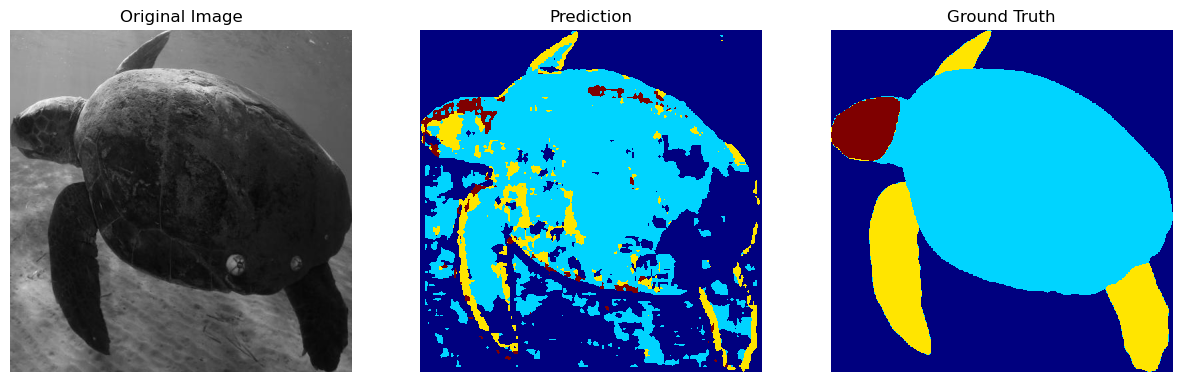

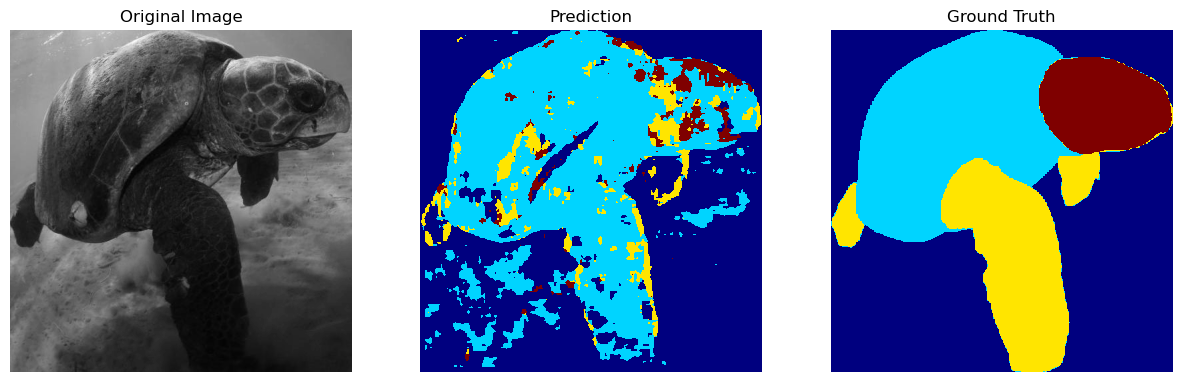

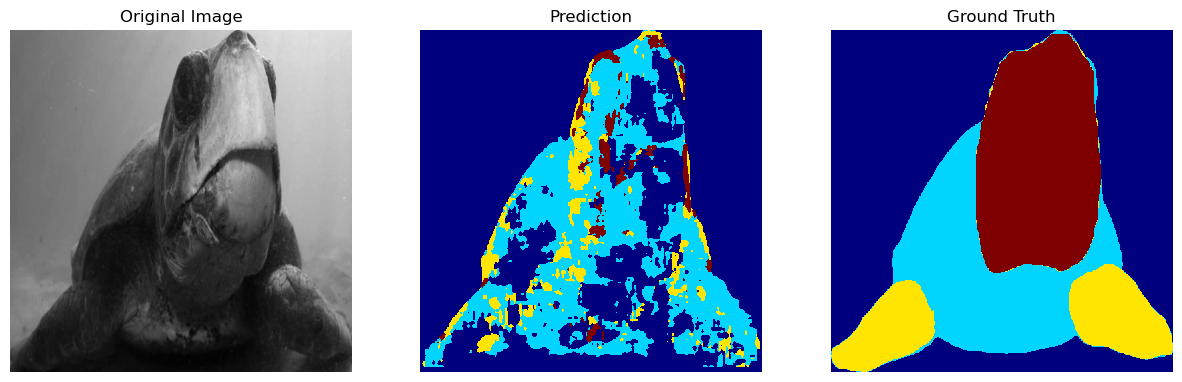

In [32]:
display_limit = 3
display_count = 0 

for images, masks in test_loader:
    if display_count >= display_limit:
        break 
    # Get the model’s predictions for the current batch of images
    outputs = model(images)
    # Convert the model output to class predictions for each pixel, then convert to a NumPy array
    predictions = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()
    # Convert the ground truth masks to a NumPy array for visualization
    ground_truth = masks.squeeze(0).cpu().numpy()
    # Convert the image to a displayable format (CHW to HWC format)
    original_image = images.squeeze(0).cpu().numpy().transpose(1, 2, 0) 
    # Call the function to plot the original image, prediction, and ground truth side by side
    plot_prediction_vs_ground_truth(original_image, predictions, ground_truth, class_to_name)
    display_count += 1 